<a href="https://colab.research.google.com/github/ghtaro/MNIST/blob/master/MNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10-Class Classification of MNIST Dataset

In [0]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# If you want to remove "future warnings" etc.
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")

# Mount Google Drive

In [0]:
gd_mount_path = '/content/drive'
from google.colab import drive
drive.mount(gd_mount_path)

In [0]:
gd_root_path = '/content/drive/My Drive/Colab Notebooks/MNIST'
gd_material_path = os.path.join(gd_root_path, 'material')
gd_data_path = os.path.join(gd_root_path, 'data')
sys.path.append(gd_material_path)

gd_utils_path = '/content/drive/My Drive/Colab Notebooks/Utils'
gd_pictures_path = '/content/drive/My Drive/Colab Notebooks/Pictures'

sys.path.append(gd_utils_path)
sys.path.append(gd_pictures_path)

try:
    del sys.modules['tool']
except Exception as e:
    pass
import tool

# Load Training / Test Data

In [0]:
x_train, y_train, x_test, y_test = tool.load_mnist(gd_data_path)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


# まずデータセット（数字の「５」の画像）を確認

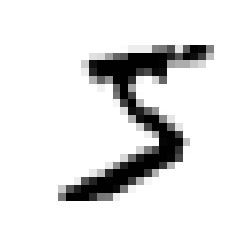

5


In [0]:
def show_digit(x, nx, ny):
    xin = x.reshape(nx, ny)
    plt.imshow(x, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

show_digit(x_train[0], 28, 28)
print(y_train[0])

# 訓練データをシャッフルして、数字の出現確率を一様にする

In [0]:
# shuffle data set to avoid that each fold in cross validation has uniform distribution. 
shuffle_idx = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_idx], y_train[shuffle_idx]

# 【2クラス分類】「５」かそれ以外か？

In [0]:
x_train_1d = x_train.reshape(60000, 784)
y_train_5 = (y_train == 5)

## SGD Linear Classifier
SGD(確率的勾配降下法)を利用した線形モデル分類
- SGD: 各ステップで、訓練セットから、無作為に１つのインスタンスを選び、そのインスタンスだけ使って、勾配を計算・モデルパラメータを更新する。
- 線形モデル分類：線形関数+Sigmoid（多クラスならSoftmax）関数を使った分類モデル。

In [0]:
from sklearn.linear_model import SGDClassifier

# Training
sgd_clf = SGDClassifier(random_state=42) # magic number
sgd_clf.fit(x_train_1d, y_train_5)

# Test
test_idx = 36000
sgd_clf.predict([x_train_1d[test_idx]])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([False])

## 性能指標
分類問題で代表的な性能指標を列記する。以下、N個のインスタンスからなる検証セットがあると仮定する。

### 正解率 (Accuracy)
- N個のうち、M個だけ正解（正しいラベルを予測）した場合、$Acc=\frac{M}{N}$
- 分類器の性能指標として、Accuracyはあまり好まれない。理由は、"skewed dataset"（歪んだデータセット：上記の例なら、数字５は、データ全体の10％程度、5以外は90％程度と、出現頻度が歪んでいる）では、ランダムな分類器でも、90％程度のAccuracyを達成できるので、指標としてあてにならないから。

**混合行列（Confusion Matrix）**を作って、意味を理解する。


>$Acc=\frac{TP+TN}{TP+FN+FP+TN}$


### F値 (F1 Score)
- モデルの優劣を評価するには、Accuracyより、「正解ラベルの付いたインスタンスを正解と判別する確率」のようなものを、性能指標にするべき。
- ２つの指標: 予測の「適合率(Precision)」と「再現率(Recall)」がよく利用される。

- Precision: Positive（数字５）と予測したときの予測精度(Precision)。
>$Prec=\frac{TP}{TP+FN}$

    - 例えば、**「社内ウェブフィルター（無害なウェブサイトをPositiveと判断）」のような「Positiveの判断」を外したくない**とき、Precisionの高いモデルを訓練したい。
    - もし、Positive(無害)と判断し、フィルターに通ったサイトに、少しでもNegative(有害)なものが混じっているとまずい→**高いPrecisionを要求**
    - 他方、Negative(有害)と判断したが、実際Positive(無害)だった場合は、会社的には、「厳しいフィルターを利用している」だけなので、問題ない→**高いRecallは要求されない**
    
- Recall: 他のPositiveインスタンスを、正しくPositiveと予測できるかという精度。
>$Rec=\frac{TP}{TP+FP}$

    - 例えば、**「異常検知（異常ならPositive）」のような「Positiveの全てのインスタンス」をミスしたくない**とき、Recallの高いモデルを訓練したい。
    - もし、「Positive(異常)の取りこぼし」があると、会社が大きな損失を被る可能性あり。→**高いRecallを要求**
    - 他方、「Positive(異常)の判断」が外れても、モニタリングしている人の「異常でない」ことを確認作業回数が増えるだけ。→**高いPrecisionは要求されない**


- F1 Scoreは、２つの指標が両方大きいときに、大きくなるよう設計されている。

> $F_1=\frac{2}{\frac{1}{Prec}+\frac{1}{Rec}}=\frac{TP}{TP+\frac{FN+FP}{2}}$

- PrecisionとRecallはトレードオフの関係にある。

    - Decision Threshold(決定しきい値)を動かしていくと、PrecisionとRecallが互いに逆の方向に動くことがわかる。【TODO】
    - PR(Precision / Recall)曲線：PrecisionとRecallの値を設定するとき、PR曲線を描き、（プロジェクトに依るが）バランスのよい場所を決めることがある。

### ROC AUC (Receiver Operating Characteristic: 受信者動作特性, Area Under the Curve: 曲線の下の面積)
#### ROC曲線
2項分類器でよく利用される、性能指標。PR曲線はPrecisionとRecallを閾値を変えて、2Dプロットしたものだが、ROC曲線では、以下をプロット。
- x軸：FPR(False Posirive Ratio)
>$FPR=\frac{FP}{TN+FP}$

- y軸：TPR(True Positive Ratio)
>$TPR=\frac{TP}{FN+TP}$

#### ROC AUC
ROC曲線によって囲まれた面積。大きいほど（$FPR$は小さくし、$TPR$は大きくする）、優れた分類器。
- ランダムな分類器だと、$ROC AUC=0.5$
- 完璧な分類器だと、$ROC AUC=1$
- トレードオフがある：$TPR$を大きくすると、$FPR$も大きくなる。

### PR曲線 (F1 Score) or ROC曲線(ROC AUC)
以下のようなケースでは、PR曲線を用いたほうが、良いらしい。
- Skewed datasetでPositiveクラスが珍しい(5 or 5以外のようなケース)
- 偽陰性(False Negative)より偽陽性(False Positive)の方が気になる。


理由は、ROC AUCでは、Skewが強くFPが大きいケースなどで、FPRが大きくなり、AUCが大きくなる傾向があるから。下記のSGDでは、F1=79%, ROC AUC=96%となっており、ROC AUCをモデル訓練の最適化関数にすると、学習がうまくいかなさそうに思える。

上記ケース以外は、ROC曲線を利用してもよい（色々見る限りでは、ROCを使う理由は特段なかった）。ただ、Log-likihoodとかに比べ、最小化関数に用いる合理的な理由はないため、利用価値に疑問点を持つ人が多数いる[模様](https://stats.stackexchange.com/questions/210700/how-to-choose-between-roc-auc-and-f1-score)。個人的には、どうせ、likelihood使うので、参考程度に見ればよいかと。

## k-交差検証（k-Cross Validation）

- k-交差検証とは、「訓練セットをk個のフォールドに分割し、(k-1)セットをモデル訓練に利用し、残りの1セットをモデル検証に利用しスコアを算出。k通りでそれぞれスコアを算出し、モデル評価する手法」。
- メリットは
    - 検証セットを用意することで、テストセットに手を付けず、モデルを第三者的に、評価できる。
    - スコアだけでなく、スコアの標準偏差（k個のスコアから算出）も計算することが出来るため、スコアの有意性の判断もできる。

[Picture]

- まずは、精度（Accuracy）を確認。
- SGD線形モデルで95％の精度（Accuracy）達成。いいモデルなのか？

In [0]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train_1d, y_train_5, cv=3, scoring="accuracy")

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

array([0.96935, 0.9653 , 0.9636 ])

いつも「Negative(5以外)」と予測する分類器を使えば、90％の精度。性能指標が良くない。

In [0]:
#  classifier (Always NOT five)
# ACCURACY IS NOT SUITABLE FOR CHECKING THE QUALITY OF CLASSIFIER MODEL!!
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train_1d, y_train_5, cv=3, scoring="accuracy")

array([0.9111 , 0.9066 , 0.91125])

## 混合行列（Confusion Matrix）, Precision, Recall and F1 Score

Precision~75%, Recall~83%とRecallの方が高いスコア。このモデルを分析する。
- **「Positiveの取りこぼし」が無いようモデルが作られ、Recallが高い。**
- それ故に、Negativeなものまで、Positiveと判断しがち**「Positiveの判断力（精度）」が比較して低く、Precisionが低い。**

仮に、PrecisionとRecallをバランスよく精度良いものにしたいなら、もう少しRecallを下げ、Precisionを上げるように、閾値を上昇させれば良いとわかる。

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

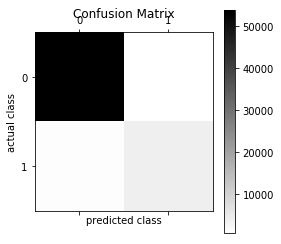

Precision=TP/(TP+FP): 0.8456512862392813
ReCall=TP/(TP+FN): 0.7640656705404907
F-value: 0.8027909681170656


In [0]:
# confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_train_predict = cross_val_predict(sgd_clf, x_train_1d, y_train_5, cv=3)
conf_mat = confusion_matrix(y_train_5, y_train_predict)
plt.matshow(conf_mat, cmap=plt.cm.binary)
plt.ylabel("actual class")
plt.xlabel("predicted class")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

print("Precision=TP/(TP+FP): " + str(precision_score(y_train_5, y_train_predict)))
print("ReCall=TP/(TP+FN): " + str(recall_score(y_train_5, y_train_predict)))
print("F-value: " + str(f1_score(y_train_5, y_train_predict)))

In [0]:
# Trade-off: 適合率と再現率
from sklearn.metrics import precision_recall_curve

y_scores = sgd_clf.decision_function(x_train_1d)
print("scores")
print(y_scores)

print("Threshold=0")
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

print("Threshold=200000")
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

y_scores = cross_val_predict(sgd_clf, x_train_1d, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

scores
[-538482.48720605 -323702.2387667  -464194.10086591 ... -434908.52184405
 -160812.32883345 -239650.46450832]
Threshold=0
[False False False ... False False False]
Threshold=200000
[False False False ... False False False]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

## PR曲線

PrecisionとRecallが交差するあたりが、バランスのとれたThresholdかもしれない。
PR曲線も良く用いる。

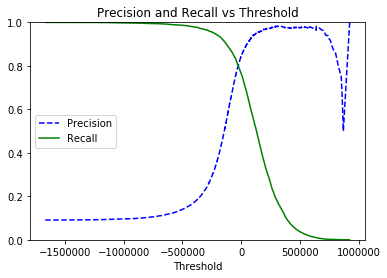

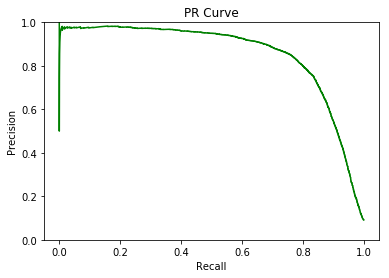

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.title("Precision and Recall vs Threshold")
    plt.ylim([0,1])

def plot_precision_vs_recall(recalls, precisions):
    plt.plot(recalls[:-1], precisions[:-1], "g-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("PR Curve")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
plot_precision_vs_recall(recalls, precisions)
plt.show()

In [0]:
# 適合率90%を保つThresholdを考える->around 70000
y_train_pred_90 = (y_scores > 70000)
print("Precision=TP/(TP+FP):（適合率）すべての５と判断した事例をとってきて、実際に５だった確率")
p_linear = precision_score(y_train_5, y_train_pred_90)
print(p_linear)
print("ReCall=TP/(TP+FN):（再現率）すべての５をとってきて、正しく判断できた確率")
r_linear = recall_score(y_train_5, y_train_pred_90)
print(r_linear)

Precision=TP/(TP+FP):（適合率）すべての５と判断した事例をとってきて、実際に５だった確率
0.9161725067385444
ReCall=TP/(TP+FN):（再現率）すべての５をとってきて、正しく判断できた確率
0.6270060874377421


## ROC曲線

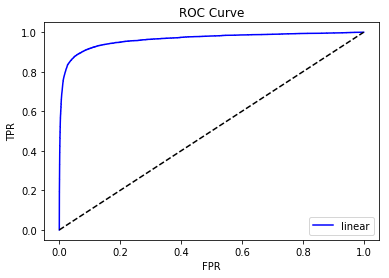

In [0]:
# ROC曲線(Receiver Operating Characteristic 受信者動作特性曲線)
# 優れた分類器はROCがy=xから、位置的に離れる傾向がある。
from sklearn.metrics import roc_curve

def plt_fprtpr_threshold(y, score, color, label):
    fpr, tpr, thresholds = roc_curve(y, score)
    plt.plot(fpr, tpr, color, label=label)
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title("ROC Curve")

plt_fprtpr_threshold(y_train_5, y_scores, "b-", "linear")
plt.show()

## ROC AUC

Skewed dataset(５以外がデータ全体の90％)なので、ROC AUCでは、大きな値が出てしまい、あまりあてにならない。他方、F1 Scoreなら79%なので、改善の余地があることが分かり、こちらの方が有用。
- F1 Score = 79% (上記参照)
- ROC AUC = 96%

In [0]:
# 分類器の比較にはROC AUCが使える。ROCAUC=1 -> Perfect classifier, ROCAUC=0.5 -> Random classifier
from sklearn.metrics import roc_auc_score

rocauc_linear = roc_auc_score(y_train_5, y_scores)
print(rocauc_linear)

0.963564543635462


## Random Forestで同じ性能指標をチェック

モデルを変えて、性能指標を上げることを考える。Random Forestを使ってみる。

'predict_proba'を指定すると、各クラスに属する（予測）確率を返す。予測確率を「スコア」そのものとして、ROC曲線を描く。

In [0]:
#  Random Forest classifierとROCAUCを比較
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, x_train_1d, y_train_5, cv = 3, method='predict_proba')

# Proba to Score
y_score_forest = y_prob_forest[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC AUCとPrecision / Recallを比較。どれをとっても、Random Forestが圧倒的に優れた結果を出した。

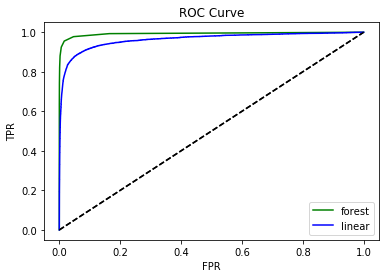

ROC AUC Forest: 0.9928259617168744
ROC AUC Linear: 0.963564543635462
Precision, Recall Rate Forest: 0.986283185840708, 0.8223574986164914
Precision, Recall Rate Linear: 0.9161725067385444, 0.6270060874377421


In [0]:
# ROC Curve
plt_fprtpr_threshold(y_train_5, y_score_forest, "g-", "forest")
plt_fprtpr_threshold(y_train_5, y_scores, "b-", "linear")
plt.show()

# ROC AUC
rocauc_forest = roc_auc_score(y_train_5, y_score_forest)
print("ROC AUC Forest: " + str(rocauc_forest))
print("ROC AUC Linear: " + str(rocauc_linear))

# 適合率と再現率
threshold = 0.5
y_score_threshod_forest = (y_score_forest > threshold)
p_forest = precision_score(y_train_5, y_score_threshod_forest)
r_forest = recall_score(y_train_5, y_score_threshod_forest)
print("Precision, Recall Rate Forest: " + str(p_forest) + ", " + str(r_forest))
print("Precision, Recall Rate Linear: " + str(p_linear) + ", " + str(r_linear))

# 【10クラス分類】 0から９のどれか？

## OVA Classifier
個々の数字のための分類器を用意する。このケースでは、0検出器、1検出器、、、9検出器の10個の分類器を用意。予測では、一番高いスコアを出した検出器の数字を予測値とする。

In [0]:
# OVA Multiclass Classifier (one-versus-all)
# y_train[i] is in [0,9]
sgd_clf.fit(x_train_1d, y_train)
pred = sgd_clf.predict([x_train_1d[10]])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [0]:
idx = 100
x_test = [x_train_1d[idx]]

decision = sgd_clf.decision_function(x_test)
decision_idx = np.argmax(decision)
decision_pred = sgd_clf.classes_[decision_idx]
print(decision)
print("The prediction is the " + str(decision_idx) + "-th class and the value is " + str(decision_pred))
print("The answer is " + str(y_train[idx]))

[[-464181.65769702 -623054.42803843 -387662.227759   -925061.37055118
  -281588.02406292  130690.83230661 -880303.81720518 -474302.66378776
   104276.60660097 -478244.96725753]]
The prediction is the 5-th class and the value is 5
The answer is 5


## OVO Classifier
1つの分類器で、２つの数字のペアのどちらかを予測する。0~9の数字なら、計45個の2項分類器を学習する。予測では、一つの画像に対し、45個の分類器すべてを実行、一番多くの勝利を勝ち取った数字を、予測値とする。
- Pros: 学習する際に、10分の２くらいの訓練セット（小規模データ）で学習すればよいこと。
- Cons: たくさん(45個)のモデルを作らないといけない。また、一般にOVAの方が精度がよいらしい（未調査）。

In [0]:
# OVO Multiclass Classifier (one-versus-one)
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train_1d, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
# Prediction
pred = ovo_clf.predict(x_test)
pred

array([5], dtype=uint8)

In [0]:
# Size of the estimator is combination of 10 (=45)
# 2-class classifier for (0,1), (0,2),...,(0,9),(1,2),...,(1,9),...(8,9)
len(ovo_clf.estimators_)

45

## Random Forest Classifier

In [0]:
# Random Forest Multiclass Classifier
forest_clf.fit(x_train_1d, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
# Test prediciton
print(forest_clf.predict(x_test))
# The probabilities of the input being each digit
print(forest_clf.predict_proba(x_test))

[5]
[[0.  0.1 0.  0.  0.  0.7 0.1 0.1 0.  0. ]]


## 3-交差検証
Accuracy（正確性）を確認。OVA < OVO < Random Forestとなっている。

In [0]:
# Cross Validation
# Here we use the "accuracy" scoring method.
# We implicitly assume that each digit appears at the same probability in the test inputs data set.
score_ova = cross_val_score(sgd_clf, x_train_1d, y_train, cv=3, scoring="accuracy") # OVA SGD (linear) classifier
score_ovo = cross_val_score(ovo_clf, x_train_1d, y_train, cv=3, scoring="accuracy") # OVO SGD (linear) classifier
score_forest = cross_val_score(forest_clf, x_train_1d, y_train, cv=3, scoring="accuracy") # Random forest classifier
print("OVA cross-validation " + str(score_ova))
print("OVO cross-validation " + str(score_ovo))
print("Random Forest cross-validation " + str(score_forest))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

OVA cross-validation [0.85772845 0.86584329 0.87903185]
OVO cross-validation [0.91716657 0.92119606 0.90728609]
Random Forest cross-validation [0.94131174 0.94234712 0.9393409 ]


In [0]:
# Apply Standard Scaler in the data preprocessing
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()
x_train_1d_norm = standardScaler.fit_transform(x_train_1d)
score_ova = cross_val_score(sgd_clf, x_train_1d_norm, y_train, cv=3, scoring="accuracy") # OVA SGD (linear) classifier
score_ovo = cross_val_score(ovo_clf, x_train_1d_norm, y_train, cv=3, scoring="accuracy") # OVO SGD (linear) classifier
score_forest = cross_val_score(forest_clf, x_train_1d_norm, y_train, cv=3, scoring="accuracy") # Random forest classifier
print("OVA cross-validation " + str(score_ova))
print("OVO cross-validation " + str(score_ovo))
print("Random Forest cross-validation " + str(score_forest))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, 

OVA cross-validation
[0.90591882 0.91339567 0.9106866 ]
OVO cross-validation
[0.91831634 0.91364568 0.91833775]
Random Forest cross-validation
[0.93916217 0.94324716 0.93809071]


## 誤分類の分析
混同行列(Confusion Matrix)を見て、どこで誤分類しているか確認。

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

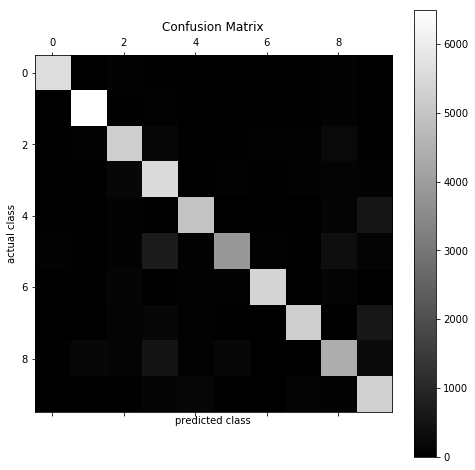

In [0]:
y_train_pred = cross_val_predict(sgd_clf, x_train_1d, y_train, cv=3)
conf_mat = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8,8))
plt.matshow(conf_mat, cmap=plt.cm.gray, fignum=1)
plt.ylabel("actual class")
plt.xlabel("predicted class")
plt.colorbar()
plt.title("Confusion Matrix")
plt.show()

### 混同行列の分析
O1: 対角成分の５は、他より暗い（白い方が優れている）→数字の５のデータは他より少ないのでは？

O2: 分類器は、数字８でよくミスっている→なぜ？

In [0]:
# Observation from the above confusion matrix
# O1: diagonal element for 5 looks darker than the others.
# -> number of data for digit 5 would be smaller than the others.
sum1 = conf_mat.sum(axis=1) # sum over the column indices
print(sum1)
print(np.argmin(sum1)) # You know this is correct for this specific case (we are working on digits 0 to 9 as the target classes.)
# -> OVA estimator does not perform well to predict 5.
sum0 = conf_mat.sum(axis=0) # sum over the row indices
accs = conf_mat.diagonal() / sum0
print(accs)

# O2: Obviously the estimator makes more mistakes to predict digit 8 for a given input than other digits. -> Why??
print(np.argmin(accs))

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
5
[0.95572207 0.94056248 0.85184585 0.75261229 0.91233529 0.89542484
 0.95817827 0.9287613  0.7844674  0.74918289]
9


誤分類の絶対数ではなく（画像数が多い方が、非対角成分を多く持つはずなので）、誤り率を見たい。

下の正規化したConfusion Matrixから読み取れること
- 全体的に、８，９でよく間違えている。
- 他方、１や２は、ほとんど誤分類がない。
- 5を３に、7を9に、誤分類している。
- 誤分類は対称的ではない。5を3によく間違えているが、3を5に間違えてはいない。

分類の改善方法案として（本参照）
- 単純に訓練データを増やす
- 8,9の分類：閉じた輪の数を数えるアルゴリズム、データ前処理して閉じた輪を目立たせるようにする
- 3/5の誤分類：SGD線形分類器は、各ピクセルの明度に、重みかけて、足してるだけ。３，５は少数のピクセルの違いだけなので、間違えやすいとのこと。


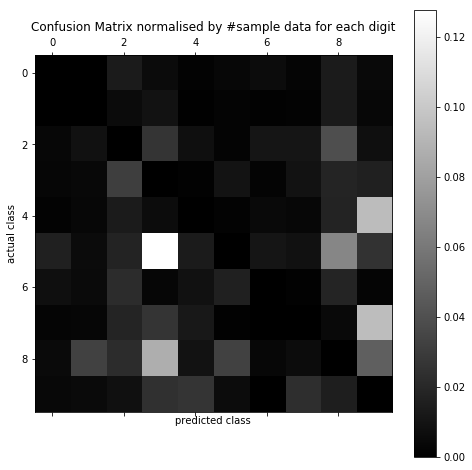

In [0]:
# Divide each element of the confusion matrix by the number of sample data for each digit
row_sums = conf_mat.sum(axis=1, keepdims=True)
nor_conf_max = conf_mat / row_sums
np.fill_diagonal(nor_conf_max, 0) # fill diagonal with 0 (we want to focus on the wrong judge)

plt.figure(figsize=(8,8))
plt.matshow(nor_conf_max, cmap=plt.cm.gray, fignum=1)
plt.xlabel("predicted class")
plt.ylabel("actual class")
plt.colorbar()
plt.title("Confusion Matrix normalised by #sample data for each digit")
plt.show()

# 多ラベル分類

In [0]:
# Multi-Label Classification (K-neighbours classifier)
# 簡単な例: ラベル１→大きい数字かどうか(7 or 8 or 9なら１、違えば０)、ラベル２→奇数なら１、違えば0
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_1d, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [0]:
pred = knn_clf.predict(x_test)
print("prediction")
print(pred)
print("answer")
print(y_multilabel[idx])

prediction
[[False  True]]
answer
[False  True]


In [0]:
# Model validatiaon
# simple average over F-values on each label
y_train_knn_pred = cross_val_predict(knn_clf, x_train_1d, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") # "macro"

#多出力分類

In [0]:
# Multioutputs-Multiclass Classifier

shuffle_idx = np.random.permutation(10000)
x_test, y_test = x_test[shuffle_idx], y_test[shuffle_idx]
x_test_1d = x_test.reshape(10000, 784)

noise = np.random.randint(0, 100, (len(x_train_1d), 784))
x_train_mod = x_train_1d + noise
noise = np.random.randint(0, 100, (len(x_test_1d), 784))
x_test_mod = x_test_1d + noise
y_train_mod = x_train_1d
y_test_mod = x_test_1d